## Workshop 3: Estimating the onset of the Rainy Season

<img src="../images/partners.png" width="50%"/>


The learning objectives of this workshop are to understand:
1. The retrieval of point precipitation data through the Google Earth Engine API.
3. The parameters that help define the onset date of the rainy season.
4. The application of a rolling window to determine the onset of the rainy season.
5. The visualization of the results.


#### It is strongly encouraged to change parts of this notebook, for instance the point of interest, time period, data layers.

## Importing Google Earth Engine API
See the GEE_authenticate.ipynb script for more information on
connecting with the Google Earth Engine API

In [1]:
import ee
ee.Authenticate()

True

Authenticate using ee: 
- This command will open a new window asking you to sign in with your Google Account.
- Then you will have to enable permissions for the notebook to access your Google Account.
- The authentication flow will generate a token which you will need to provide in a pop-up box.
- The token will be saved and valid for a week.

In [3]:
# Initialize your project, using the project ID you took note of during
# the creation of your Google Earth Engine Project
projectID = 'ee-hkvdeveloper'
ee.Initialize(project=projectID)

Now that you are authenticated and have initialized your project we are able to use Google Earth Engine API.

## Import Python packages

In [4]:
import geemap
import pandas as pd
import matplotlib.pyplot as plt

If the packages are not already installed, run:\
!pip install earthengine-api geemap pandas matplotlib

## Select point location and time period for subsetting the data
Feel free to adjust the location and the time period according to your interests.

In [5]:
# Specify latitude and longitude of point of interest
point_lat = -20
point_lon = 46

# Define your point of interest (default, Madagascar)
point_of_interest = ee.Geometry.Point([point_lon, point_lat])

# Define time parameters
start_date = '2017-01-01'
end_date = '2020-12-31'

## Visualize location of point of interest
Here, we visualize the point of interest using the geemap package.

In [6]:
# Create a Map and add the point
Map = geemap.Map()
# Center the map based on the region of interest
Map.centerObject(point_of_interest, 5)
# Add the CHIRPS precipitation layer and assign a style
Map.addLayer(point_of_interest)
Map.addLayerControl()
Map

Map(center=[-20.000000000000004, 45.99999999999999], controls=(WidgetControl(options=['position', 'transparent…

## Subset the data
Next step is to retrieve the CHIRPS precipitation data at the point of interest.

In [7]:
# Access the CHIRPS dataset
chirps_dataset = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate(start_date, end_date)

# Function to retrieve precipitation for a point
def get_precip_at_point(image):
    precip_value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point_of_interest, scale=30).get('precipitation')
    return ee.Feature(None, {'date': image.date().format(), 'precip': precip_value})

# Retrieve the precipitation timeseries at the specified point
# Map the function over the dataset to create a FeatureCollection (Google Earth Engine)
precip_ts = chirps_dataset.map(get_precip_at_point)

# Extract the time series as a list
precip_list = precip_ts.reduceColumns(ee.Reducer.toList(2), ['date', 'precip']).get('list')

# Use getInfo() to retrieve the data for further analysis in Python
precip_data = precip_list.getInfo()

Now that we have subsetted the point data we can specify the parameters that determine the onset date of the rainy season

## Estimating the onset of the rainy season

The definition of the onset of the rainy season varies between researchers and water practitioners. This results also in a wide range of methods that can be used to determine the onset of the rainy season. Here, we demonstrate a simple method that might not be applicable to your use case.

## Parameters defining onset of the rainy season


Now that we have subsetted the point data, the first step is to specify the parameters that define the onset date of the rainy season.\
Feel free to adjust these settings

In [8]:
#The minimum cumulative volume of rainfall over the rolling window period (window_days)
rainfall_threshold = 50  # mm/day

# Rolling window, for each number of window_days the year is iteratively processed
window_days = 7

# Starting month, select a month of the year that is known to not be part of the rainy season
# This avoids conflicting results when the first day of the year is part of the rainy season
dry_month = 5

Explanation of the window_days parameter (rolling window):

![Create a Project](images/rollingwindow.png)

## Identify threshold exceedance based on rolling window

The second step is to identify for each rolling window the cummulative precipitation threshold exceedance.

In [9]:
# Convert the list of data into a DataFrame
df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Adjust the DataFrame to shift dates so that the year starts in your dry month,
# This creates a new column 'AdjustedYear' to group by
df['AdjustedYear'] = df.index.year + (df.index.month >= dry_month).astype(int)

# Calculate the rolling sum over the specified window
df['RollingSum'] = df['Precipitation'].rolling(window=window_days).sum()

# Identify exceedances
df['ExceedsThreshold'] = df['RollingSum'] > rainfall_threshold

## Report first and last exceedance date

Third step is to adjust years to start at the specified dry month\
and calculate first and last date of exceedance for each year.

In [10]:
# Group the DataFrame by year
grouped = df.groupby('AdjustedYear')

# Initialize an empty dictionary to store the first and last exceedance dates for each year
exceedances_summary = {}

# Loop through each group (year) to find the first and last exceedance      
for year, group in grouped:
    # Check if there are any exceedances in the year
    exceedances = group[group['ExceedsThreshold']]
    
    if not exceedances.empty:
        # Find the first and last exceedance dates
        first_exceedance_date = exceedances.index.min()
        last_exceedance_date = exceedances.index.max()
        exceedances_summary[year] = (first_exceedance_date, last_exceedance_date)

## Visualize results

Final step is to interpret and visualize the results.

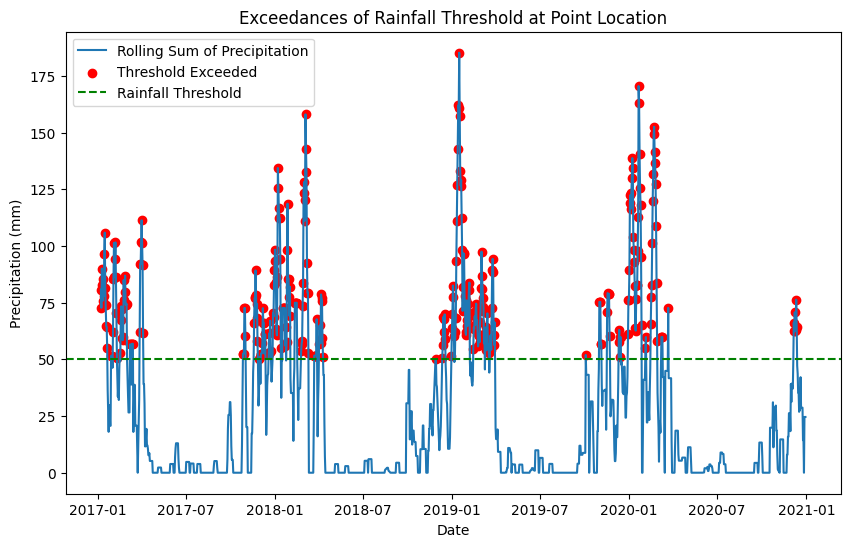

Year 2017: First exceedance on 2017-01-07, Last exceedance on 2017-04-04
Year 2018: First exceedance on 2017-10-27, Last exceedance on 2018-04-10
Year 2019: First exceedance on 2018-11-29, Last exceedance on 2019-03-30
Year 2020: First exceedance on 2019-10-04, Last exceedance on 2020-03-22
Year 2021: First exceedance on 2020-12-06, Last exceedance on 2020-12-12


In [11]:
exceedances = df[df['ExceedsThreshold']]

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['RollingSum'], label='Rolling Sum of Precipitation')
plt.scatter(exceedances.index, exceedances['RollingSum'], color='r', label='Threshold Exceeded')
plt.axhline(y=rainfall_threshold, color='g', linestyle='--', label='Rainfall Threshold')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Exceedances of Rainfall Threshold at Point Location')
plt.legend()
plt.show()


# Print the first and last exceedance date for each year
for year, dates in exceedances_summary.items():
    print(f"Year {year}: First exceedance on {dates[0].date()}, Last exceedance on {dates[1].date()}")

Note that in the case of Madagascar the rainy season is part of the month January, therefore the first year should be discarded from the analysis.

## You have sucessfully estimated the onset of the rainy season!

Please try to:
- Select different points of interest and compare the results.
- Select region of interest instead of point of interest (see GEE_authenticate.ipynb, for more information).
- Select different precipitation dataset and compare the results.
- Compare results to precipitation station data.
